In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ingestion

In [77]:
df_tickers = pd.read_csv('tickers-1.csv')
df_market_data = pd.read_csv('market_data_ml.csv')

df_market_data.head()

,date,ticker,open,high,low,close,volume
0,2023-01-02,AAPL,298.68,299.98,297.91,298.32,4455736
1,2023-01-03,AAPL,299.46,300.85,298.99,299.47,4842514
2,2023-01-04,AAPL,298.01,298.58,297.48,298.15,4797919
3,2023-01-05,AAPL,299.50,300.09,299.04,299.14,1045665
4,2023-01-06,AAPL,299.74,299.97,298.78,299.35,2635239


In [78]:
dfs = []
for ticker in df_tickers['symbol']:
    dfs.append(df_market_data[df_market_data['ticker'] == ticker])
    globals()['df_%s' % ticker.lower()] = df_market_data[df_market_data['ticker'] == ticker]

df_aapl.head()
# df_amzn.head()

,date,ticker,open,high,low,close,volume
0,2023-01-02,AAPL,298.68,299.98,297.91,298.32,4455736
1,2023-01-03,AAPL,299.46,300.85,298.99,299.47,4842514
2,2023-01-04,AAPL,298.01,298.58,297.48,298.15,4797919
3,2023-01-05,AAPL,299.50,300.09,299.04,299.14,1045665
4,2023-01-06,AAPL,299.74,299.97,298.78,299.35,2635239


# Features

In [79]:

# Process each dataframe in dfs
for i, df in enumerate(dfs):
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure date column is datetime and sort by date
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # Calculate daily returns (using pandas pct_change)
    df['daily_return'] = df['close'].pct_change()
    
    # Calculate log returns (using numpy)
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    # Create lag features for returns (1-day, 3-day, 5-day) - using pandas shift
    df['return_lag_1'] = df['daily_return'].shift(1)
    df['return_lag_3'] = df['daily_return'].shift(3)
    df['return_lag_5'] = df['daily_return'].shift(5)
    
    # Add Simple Moving Averages (SMA) - using pandas rolling
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_10'] = df['close'].rolling(window=10).mean()
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    
    # Add RSI using pandas/numpy
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # Add MACD using pandas ewm (exponential weighted moving average)
    ema_fast = df['close'].ewm(span=12, adjust=False).mean()
    ema_slow = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_fast - ema_slow
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_histogram'] = df['macd'] - df['macd_signal']

    df['direction'] = np.where(df['daily_return'] > 0, 1, 0)
    
    # Update the dataframe in the list
    dfs[i] = df
    
    # Also update the global variable if it exists
    ticker = df['ticker'].iloc[0]
    if f'df_{ticker.lower()}' in globals():
        globals()[f'df_{ticker.lower()}'] = df

df_combined = pd.concat(dfs, ignore_index=True)

dfs[0].head()
# df_aapl.head()

,date,ticker,open,high,low,close,volume,daily_return,log_return,return_lag_1,...,return_lag_5,sma_5,sma_10,sma_20,sma_50,rsi,macd,macd_signal,macd_histogram,direction
0,2023-01-02,AAPL,298.68,299.98,297.91,298.32,4455736,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0
1,2023-01-03,AAPL,299.46,300.85,298.99,299.47,4842514,0.003855,0.003848,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.091738,0.018348,0.073390,1
2,2023-01-04,AAPL,298.01,298.58,297.48,298.15,4797919,-0.004408,-0.004418,0.003855,...,NaN,NaN,NaN,NaN,NaN,NaN,0.057268,0.026132,0.031136,0
3,2023-01-05,AAPL,299.50,300.09,299.04,299.14,1045665,0.003320,0.003315,-0.004408,...,NaN,NaN,NaN,NaN,NaN,NaN,0.108583,0.042622,0.065961,1
4,2023-01-06,AAPL,299.74,299.97,298.78,299.35,2635239,0.000702,0.000702,0.003320,...,NaN,298.886,NaN,NaN,NaN,NaN,0.164302,0.066958,0.097344,1


# Model

In [80]:
import json
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import seaborn as sns

In [81]:
# Load configuration files
with open('features_config.json', 'r') as f:
    features_config = json.load(f)

with open('model_params.json', 'r') as f:
    model_params = json.load(f)

# Get feature list and label name from config
feature_list = features_config['features']
label_name = features_config['label']

print(f"Features to use: {feature_list}")
print(f"Label: {label_name}")

Features to use: ['return_lag_1', 'return_lag_3', 'return_lag_5', 'sma_5', 'sma_10', 'sma_20', 'rsi', 'macd']
Label: direction


In [82]:
# Ensure date is datetime and sort by date
df_combined['date'] = pd.to_datetime(df_combined['date'])
df_combined = df_combined.sort_values('date').reset_index(drop=True)

# df_combined.head()

In [83]:
# Select features and target
X = df_combined[feature_list].copy()
y = df_combined[label_name].copy()

# Drop rows with missing values (from lag features and rolling windows)
print(f"\bBefore dropping NaN: {X.shape}")
X = X.dropna()
y = y.loc[X.index]
print(f"\bAfter dropping NaN: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Before dropping NaN: (1300, 8)
After dropping NaN: (1205, 8)
Target distribution:
direction
0    618
1    587
Name: count, dtype: int64


In [84]:
# Time-based train-test split (80-20 split)
split_idx = int(len(X) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

X_train.head()

Train set size: 964
Test set size: 241


,return_lag_1,return_lag_3,return_lag_5,sma_5,sma_10,sma_20,rsi,macd
95,-0.002947,0.010191,-0.011140,115.316,116.700,118.3940,37.813765,-1.960976
96,0.014917,-0.007800,0.001777,126.164,127.087,127.1195,45.774648,-0.386749
97,0.007170,-0.007741,0.009815,295.482,295.273,296.9630,46.862170,-0.745168
98,-0.003939,0.005938,0.009398,141.180,139.344,137.3115,65.324103,1.564445
99,-0.008119,0.002962,-0.000260,233.196,232.407,233.1725,39.025933,-0.243708


In [85]:
# Scale features (important for LogisticRegression)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

X_train_scaled.head()

,return_lag_1,return_lag_3,return_lag_5,sma_5,sma_10,sma_20,rsi,macd
95,-0.329456,1.142587,-1.249415,-0.928001,-0.908141,-0.884141,-0.689067,-1.305830
96,1.648434,-0.876234,0.204818,-0.772656,-0.759425,-0.759251,-0.218595,-0.195166
97,0.790681,-0.869624,1.109758,1.652000,1.648585,1.671765,-0.154325,-0.448042
98,-0.439218,0.665345,1.062837,-0.557625,-0.583935,-0.613370,0.936736,1.181459
99,-0.902093,0.331342,-0.024456,0.760057,0.748498,0.758714,-0.617430,-0.094247


In [86]:
# Initialize models with hyperparameters from config
lr_params = model_params['LogisticRegression']
xgb_params = model_params['XGBClassifier']

lr_model = LogisticRegression(**lr_params, random_state=42)
xgb_model = XGBClassifier(**xgb_params, random_state=42, eval_metric='logloss')

In [87]:
# Train models
print("\n" + "="*50)
print("Training Logistic Regression...")
lr_model.fit(X_train_scaled, y_train)

print("Training XGBoost...")
xgb_model.fit(X_train, y_train)


Training Logistic Regression...
Training XGBoost...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [88]:
# Make predictions
lr_pred_train = lr_model.predict(X_train_scaled)
lr_pred_test = lr_model.predict(X_test_scaled)

xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)


TEST SET PERFORMANCE

Logistic Regression:
  Accuracy:  0.6307
  Precision: 0.6892
  Recall:    0.4359

XGBoost:
  Accuracy:  0.6017
  Precision: 0.6040
  Recall:    0.5214


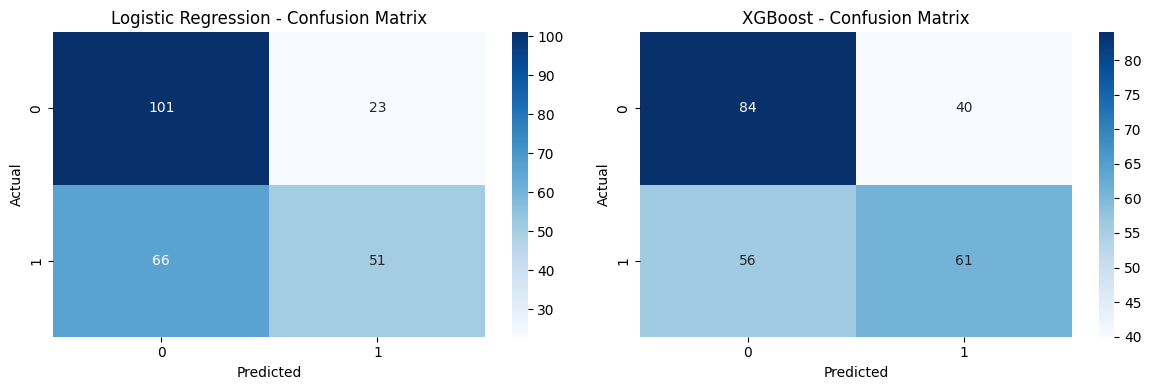


CROSS-VALIDATION RESULTS

Logistic Regression CV Accuracy:
  Mean: 0.6287 (+/- 0.0828)
  Scores: [0.58125 0.625   0.6625  0.6875  0.5875 ]

XGBoost CV Accuracy:
  Mean: 0.5825 (+/- 0.0966)
  Scores: [0.51875 0.56875 0.625   0.65    0.55   ]

DETAILED CLASSIFICATION REPORTS

Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.81      0.69       124
           1       0.69      0.44      0.53       117

    accuracy                           0.63       241
   macro avg       0.65      0.63      0.61       241
weighted avg       0.65      0.63      0.62       241


XGBoost:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       124
           1       0.60      0.52      0.56       117

    accuracy                           0.60       241
   macro avg       0.60      0.60      0.60       241
weighted avg       0.60      0.60      0.60       241


XGBOOST FEATURE IMPORTANCE
        fea

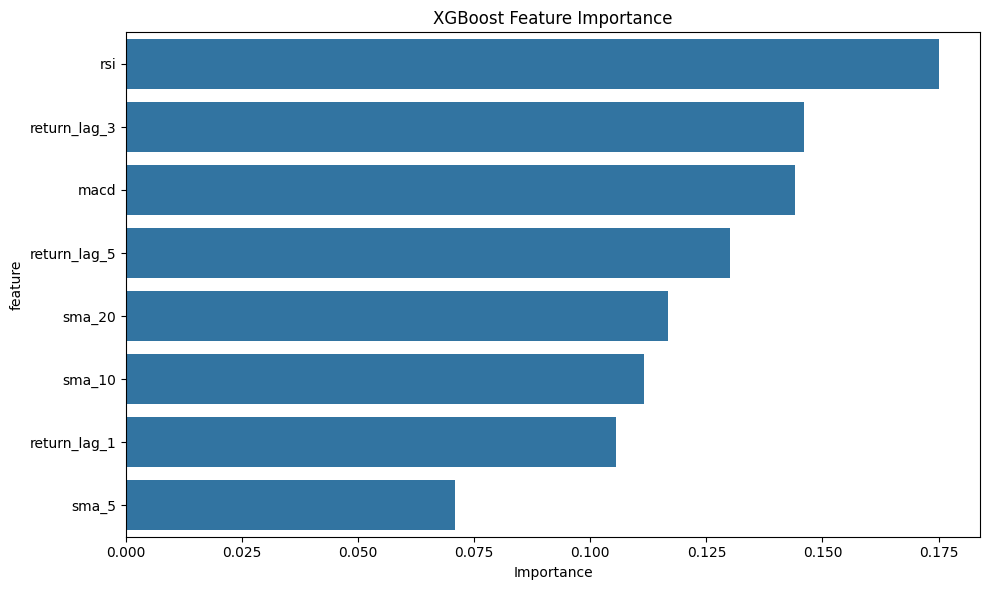

In [89]:
# Evaluate on test set
print("\n" + "="*50)
print("TEST SET PERFORMANCE")
print("="*50)

models = {
    'Logistic Regression': (lr_pred_test, y_test),
    'XGBoost': (xgb_pred_test, y_test)
}

results = {}

for model_name, (pred, true) in models.items():
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred, zero_division=0)
    recall = recall_score(true, pred, zero_division=0)
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, (model_name, (pred, true)) in enumerate(models.items()):
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{model_name} - Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Cross-Validation (Time Series Split to avoid data leakage)
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)

# Use TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation for Logistic Regression
lr_cv_scores = cross_val_score(
    lr_model, X_train_scaled, y_train,
    cv=tscv, scoring='accuracy', n_jobs=-1
)

# Cross-validation for XGBoost
xgb_cv_scores = cross_val_score(
    xgb_model, X_train, y_train,
    cv=tscv, scoring='accuracy', n_jobs=-1
)

print(f"\nLogistic Regression CV Accuracy:")
print(f"  Mean: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std() * 2:.4f})")
print(f"  Scores: {lr_cv_scores}")

print(f"\nXGBoost CV Accuracy:")
print(f"  Mean: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")
print(f"  Scores: {xgb_cv_scores}")

# Detailed classification reports
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORTS")
print("="*50)

print("\nLogistic Regression:")
print(classification_report(y_test, lr_pred_test, zero_division=0))

print("\nXGBoost:")
print(classification_report(y_test, xgb_pred_test, zero_division=0))

# Feature importance for XGBoost
print("\n" + "="*50)
print("XGBOOST FEATURE IMPORTANCE")
print("="*50)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Backtesting

In [90]:
# Signal Generation Function
def generate_signals(predictions, threshold=0.5):
    signals = predictions.copy()
    return signals

# Backtesting Function
def backtest_strategy(df, signals, initial_capital=10000, position_size=1.0):
    
    # Initialize tracking variables
    capital = initial_capital
    position = 0  # Number of shares held
    equity_curve = []
    trades = []
    
    # Align signals with dataframe
    df_backtest = df.copy()
    df_backtest['signal'] = signals
    df_backtest = df_backtest.sort_values('date').reset_index(drop=True)
    
    for i in range(len(df_backtest)):
        current_price = df_backtest.loc[i, 'close']
        current_date = df_backtest.loc[i, 'date']
        signal = df_backtest.loc[i, 'signal']
        
        # Execute trades based on signal
        if signal == 1 and position == 0:  # Buy signal, no position
            # Buy
            shares_to_buy = int((capital * position_size) / current_price)
            if shares_to_buy > 0:
                cost = shares_to_buy * current_price
                position = shares_to_buy
                capital -= cost
                trades.append({
                    'date': current_date,
                    'action': 'BUY',
                    'price': current_price,
                    'shares': shares_to_buy,
                    'capital': capital
                })
        
        elif signal == 0 and position > 0:  # Sell signal, have position
            # Sell
            proceeds = position * current_price
            capital += proceeds
            trades.append({
                'date': current_date,
                'action': 'SELL',
                'price': current_price,
                'shares': position,
                'capital': capital
            })
            position = 0
        
        # Calculate current equity (cash + position value)
        current_equity = capital + (position * current_price)
        equity_curve.append({
            'date': current_date,
            'equity': current_equity,
            'capital': capital,
            'position': position,
            'price': current_price
        })
    
    # Close any remaining position at the end
    if position > 0:
        final_price = df_backtest.loc[len(df_backtest)-1, 'close']
        capital += position * final_price
        position = 0
    
    # Create equity curve DataFrame
    equity_df = pd.DataFrame(equity_curve)
    
    # Calculate returns
    equity_df['returns'] = equity_df['equity'].pct_change()
    equity_df['cumulative_returns'] = (1 + equity_df['returns']).cumprod() - 1
    
    # Calculate performance metrics
    total_return = (capital - initial_capital) / initial_capital
    final_equity = equity_df['equity'].iloc[-1]
    
    # Calculate Sharpe ratio (annualized, assuming 252 trading days)
    if equity_df['returns'].std() > 0:
        sharpe_ratio = (equity_df['returns'].mean() / equity_df['returns'].std()) * np.sqrt(252)
    else:
        sharpe_ratio = 0
    
    # Maximum drawdown
    equity_df['cummax'] = equity_df['equity'].cummax()
    equity_df['drawdown'] = (equity_df['equity'] - equity_df['cummax']) / equity_df['cummax']
    max_drawdown = equity_df['drawdown'].min()
    
    results = {
        'initial_capital': initial_capital,
        'final_capital': capital,
        'total_return': total_return,
        'final_equity': final_equity,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'num_trades': len([t for t in trades if t['action'] == 'BUY']),
        'trades': trades
    }
    
    return results, equity_df

# Buy-and-Hold Baseline
def buy_and_hold(df, initial_capital=10000):
    """
    Calculate buy-and-hold strategy performance.
    """
    df_bh = df.copy().sort_values('date').reset_index(drop=True)
    
    # Buy at first price
    first_price = df_bh.loc[0, 'close']
    shares = int(initial_capital / first_price)
    initial_investment = shares * first_price
    
    # Calculate equity curve
    equity_curve = []
    for i in range(len(df_bh)):
        current_price = df_bh.loc[i, 'close']
        current_equity = shares * current_price
        equity_curve.append({
            'date': df_bh.loc[i, 'date'],
            'equity': current_equity,
            'price': current_price
        })
    
    equity_df = pd.DataFrame(equity_curve)
    equity_df['returns'] = equity_df['equity'].pct_change()
    equity_df['cumulative_returns'] = (1 + equity_df['returns']).cumprod() - 1
    
    final_equity = equity_df['equity'].iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital
    
    if equity_df['returns'].std() > 0:
        sharpe_ratio = (equity_df['returns'].mean() / equity_df['returns'].std()) * np.sqrt(252)
    else:
        sharpe_ratio = 0
    
    equity_df['cummax'] = equity_df['equity'].cummax()
    equity_df['drawdown'] = (equity_df['equity'] - equity_df['cummax']) / equity_df['cummax']
    max_drawdown = equity_df['drawdown'].min()
    
    results = {
        'initial_capital': initial_capital,
        'final_capital': final_equity,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'num_trades': 1  # Buy-and-hold has 1 trade (initial buy)
    }
    
    return results, equity_df

In [91]:
# Per-Ticker Backtesting
# Split test data by ticker and backtest each separately

# Prepare test data with predictions
df_test_backtest = df_combined.loc[X_test.index].copy()
df_test_backtest = df_test_backtest.sort_values('date').reset_index(drop=True)

# Add predictions to test dataframe
df_test_backtest['lr_pred'] = lr_pred_test
df_test_backtest['xgb_pred'] = xgb_pred_test

# Get unique tickers
unique_tickers = df_test_backtest['ticker'].unique()
print(f"Tickers to backtest: {unique_tickers}")
print("="*80)

# Initialize storage for results
lr_ticker_results = {}
xgb_ticker_results = {}
bh_ticker_results = {}

lr_ticker_equity = {}
xgb_ticker_equity = {}
bh_ticker_equity = {}

initial_capital_per_ticker = 10000  # Capital allocated per ticker

# Backtest each ticker separately
for ticker in unique_tickers:
    print(f"\nBacktesting {ticker}...")
    
    # Get data for this ticker only
    df_ticker = df_test_backtest[df_test_backtest['ticker'] == ticker].copy()
    df_ticker = df_ticker.sort_values('date').reset_index(drop=True)
    
    if len(df_ticker) == 0:
        print(f"  No test data for {ticker}, skipping...")
        continue
    
    # Get signals for this ticker
    lr_signals_ticker = df_ticker['lr_pred'].values
    xgb_signals_ticker = df_ticker['xgb_pred'].values
    
    # Run backtests for this ticker
    lr_res, lr_eq = backtest_strategy(
        df_ticker,
        pd.Series(lr_signals_ticker, index=df_ticker.index),
        initial_capital=initial_capital_per_ticker
    )
    
    xgb_res, xgb_eq = backtest_strategy(
        df_ticker,
        pd.Series(xgb_signals_ticker, index=df_ticker.index),
        initial_capital=initial_capital_per_ticker
    )
    
    bh_res, bh_eq = buy_and_hold(df_ticker, initial_capital=initial_capital_per_ticker)
    
    # Store results
    lr_ticker_results[ticker] = lr_res
    xgb_ticker_results[ticker] = xgb_res
    bh_ticker_results[ticker] = bh_res
    
    lr_ticker_equity[ticker] = lr_eq
    xgb_ticker_equity[ticker] = xgb_eq
    bh_ticker_equity[ticker] = bh_eq
    
    print(f"  LR: Return={lr_res['total_return']*100:.2f}%, Sharpe={lr_res['sharpe_ratio']:.2f}, Trades={lr_res['num_trades']}")
    print(f"  XGB: Return={xgb_res['total_return']*100:.2f}%, Sharpe={xgb_res['sharpe_ratio']:.2f}, Trades={xgb_res['num_trades']}")
    print(f"  B&H: Return={bh_res['total_return']*100:.2f}%, Sharpe={bh_res['sharpe_ratio']:.2f}")

# Aggregate results across all tickers
print("\n" + "="*80)
print("AGGREGATE RESULTS (Sum across all tickers)")
print("="*80)

def aggregate_results(ticker_results_dict):
    """Aggregate results across tickers"""
    total_initial = sum(r['initial_capital'] for r in ticker_results_dict.values())
    total_final = sum(r['final_capital'] for r in ticker_results_dict.values())
    total_return = (total_final - total_initial) / total_initial
    
    # Weighted average Sharpe (by capital)
    weighted_sharpe = sum(
        r['sharpe_ratio'] * r['initial_capital'] 
        for r in ticker_results_dict.values()
    ) / total_initial if total_initial > 0 else 0
    
    # Average max drawdown
    avg_drawdown = np.mean([r['max_drawdown'] for r in ticker_results_dict.values()])
    
    # Total trades
    total_trades = sum(r.get('num_trades', 0) for r in ticker_results_dict.values())
    
    return {
        'total_initial': total_initial,
        'total_final': total_final,
        'total_return': total_return,
        'weighted_sharpe': weighted_sharpe,
        'avg_drawdown': avg_drawdown,
        'total_trades': total_trades
    }

# lr_ticker_results

lr_aggregate = aggregate_results(lr_ticker_results)
xgb_aggregate = aggregate_results(xgb_ticker_results)
bh_aggregate = aggregate_results(bh_ticker_results)

print(f"\n{'Metric':<25} {'Logistic Regression':<25} {'XGBoost':<25} {'Buy & Hold':<25}")
print("-"*100)
print(f"{'Total Initial Capital':<25} ${lr_aggregate['total_initial']:>23,.2f} ${xgb_aggregate['total_initial']:>23,.2f} ${bh_aggregate['total_initial']:>23,.2f}")
print(f"{'Total Final Capital':<25} ${lr_aggregate['total_final']:>23,.2f} ${xgb_aggregate['total_final']:>23,.2f} ${bh_aggregate['total_final']:>23,.2f}")
print(f"{'Total Return':<25} {lr_aggregate['total_return']*100:>23.2f}% {xgb_aggregate['total_return']*100:>23.2f}% {bh_aggregate['total_return']*100:>23.2f}%")
print(f"{'Weighted Avg Sharpe':<25} {lr_aggregate['weighted_sharpe']:>23.2f} {xgb_aggregate['weighted_sharpe']:>23.2f} {bh_aggregate['weighted_sharpe']:>23.2f}")
print(f"{'Average Max Drawdown':<25} {lr_aggregate['avg_drawdown']*100:>23.2f}% {xgb_aggregate['avg_drawdown']*100:>23.2f}% {bh_aggregate['avg_drawdown']*100:>23.2f}%")
print(f"{'Total Number of Trades':<25} {lr_aggregate['total_trades']:>23} {xgb_aggregate['total_trades']:>23} {'N/A':>23}")

# Per-ticker performance table
print("\n" + "="*80)
print("PER-TICKER PERFORMANCE")
print("="*80)

per_ticker_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'LR Return (%)': [lr_ticker_results[t]['total_return']*100 for t in unique_tickers],
    'LR Sharpe': [lr_ticker_results[t]['sharpe_ratio'] for t in unique_tickers],
    'LR Trades': [lr_ticker_results[t]['num_trades'] for t in unique_tickers],
    'XGB Return (%)': [xgb_ticker_results[t]['total_return']*100 for t in unique_tickers],
    'XGB Sharpe': [xgb_ticker_results[t]['sharpe_ratio'] for t in unique_tickers],
    'XGB Trades': [xgb_ticker_results[t]['num_trades'] for t in unique_tickers],
    'B&H Return (%)': [bh_ticker_results[t]['total_return']*100 for t in unique_tickers],
    'B&H Sharpe': [bh_ticker_results[t]['sharpe_ratio'] for t in unique_tickers]
})

print(per_ticker_df.to_string(index=False))

Tickers to backtest: ['AMZN' 'TSLA' 'MSFT' 'AAPL' 'GOOG']

Backtesting AMZN...
  LR: Return=-1.26%, Sharpe=-1.64, Trades=6
  XGB: Return=-0.39%, Sharpe=-0.43, Trades=9
  B&H: Return=-2.50%, Sharpe=-0.49

Backtesting TSLA...
  LR: Return=1.08%, Sharpe=0.82, Trades=9
  XGB: Return=2.01%, Sharpe=1.50, Trades=10
  B&H: Return=3.85%, Sharpe=2.12

Backtesting MSFT...
  LR: Return=0.01%, Sharpe=0.07, Trades=9
  XGB: Return=2.37%, Sharpe=0.96, Trades=12
  B&H: Return=-1.29%, Sharpe=-0.03

Backtesting AAPL...
  LR: Return=-0.99%, Sharpe=-1.09, Trades=9
  XGB: Return=-0.76%, Sharpe=-0.63, Trades=10
  B&H: Return=-2.99%, Sharpe=-0.65

Backtesting GOOG...
  LR: Return=-4.87%, Sharpe=-2.89, Trades=9
  XGB: Return=-10.93%, Sharpe=-6.27, Trades=11
  B&H: Return=-14.93%, Sharpe=-5.88

AGGREGATE RESULTS (Sum across all tickers)

Metric                    Logistic Regression       XGBoost                   Buy & Hold               
------------------------------------------------------------------------

# Vizualization

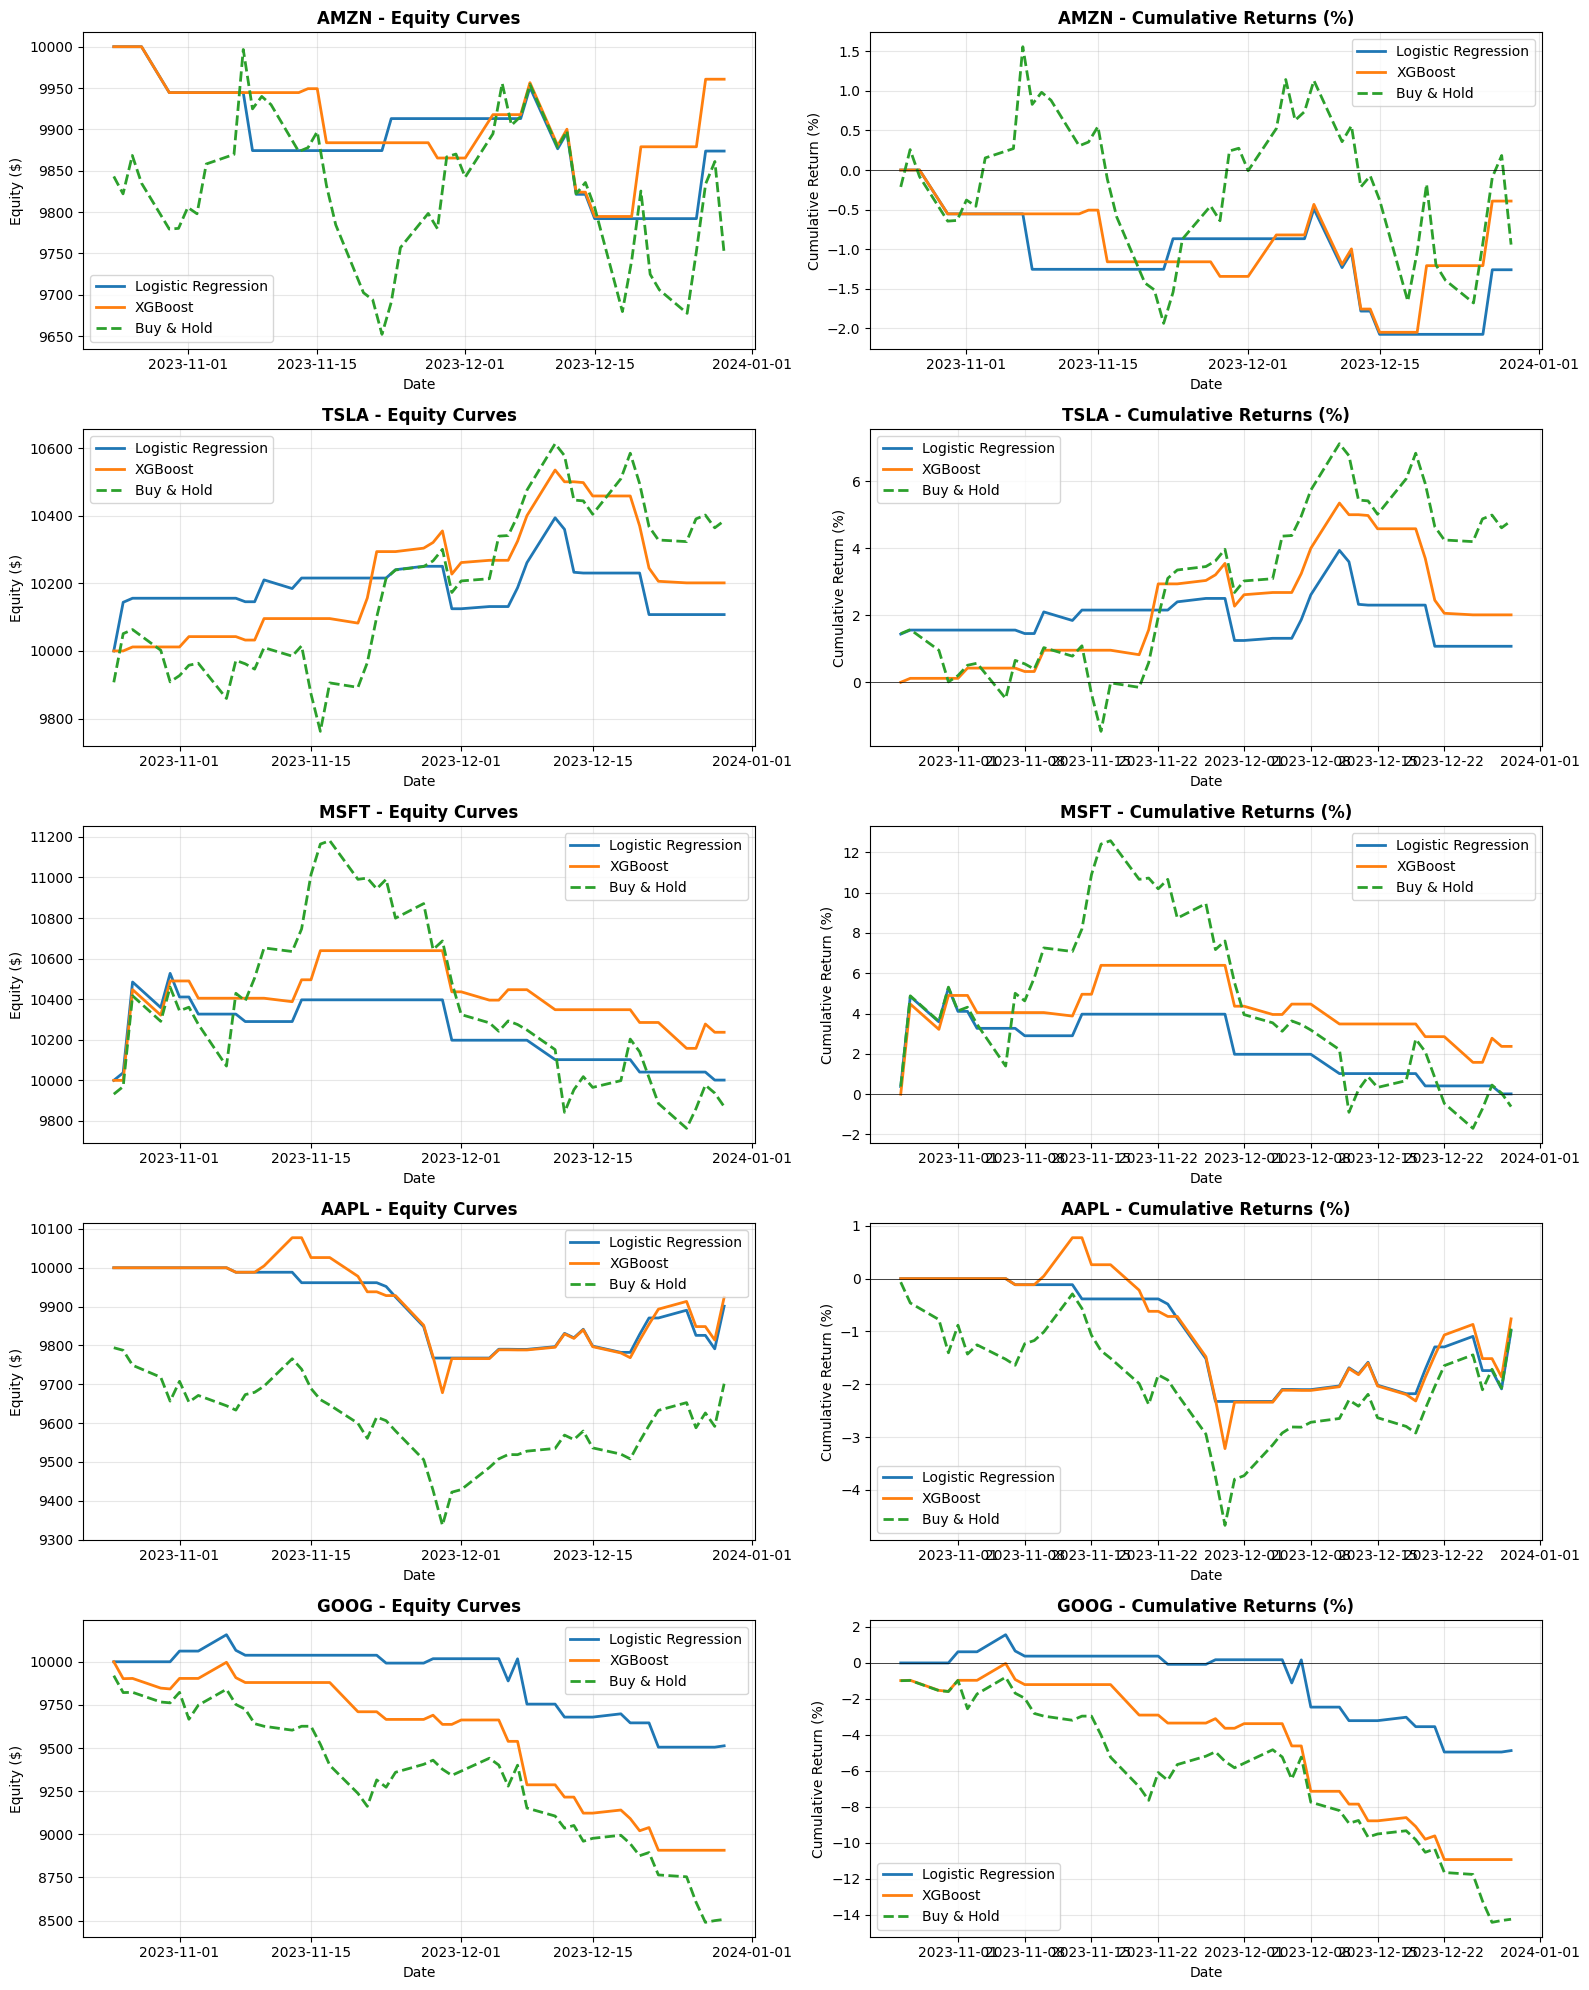

In [92]:
# Visualize Per-Ticker Performance
num_tickers = len(unique_tickers)
fig, axes = plt.subplots(num_tickers, 2, figsize=(16, 4*num_tickers))

if num_tickers == 1:
    axes = axes.reshape(1, -1)

for idx, ticker in enumerate(unique_tickers):
    # Equity curves for this ticker
    ax1 = axes[idx, 0]
    lr_eq = lr_ticker_equity[ticker]
    xgb_eq = xgb_ticker_equity[ticker]
    bh_eq = bh_ticker_equity[ticker]
    
    ax1.plot(lr_eq['date'], lr_eq['equity'], label='Logistic Regression', linewidth=2)
    ax1.plot(xgb_eq['date'], xgb_eq['equity'], label='XGBoost', linewidth=2)
    ax1.plot(bh_eq['date'], bh_eq['equity'], label='Buy & Hold', linewidth=2, linestyle='--')
    ax1.set_title(f'{ticker} - Equity Curves', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Equity ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Cumulative returns for this ticker
    ax2 = axes[idx, 1]
    ax2.plot(lr_eq['date'], lr_eq['cumulative_returns']*100, label='Logistic Regression', linewidth=2)
    ax2.plot(xgb_eq['date'], xgb_eq['cumulative_returns']*100, label='XGBoost', linewidth=2)
    ax2.plot(bh_eq['date'], bh_eq['cumulative_returns']*100, label='Buy & Hold', linewidth=2, linestyle='--')
    ax2.set_title(f'{ticker} - Cumulative Returns (%)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Return (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

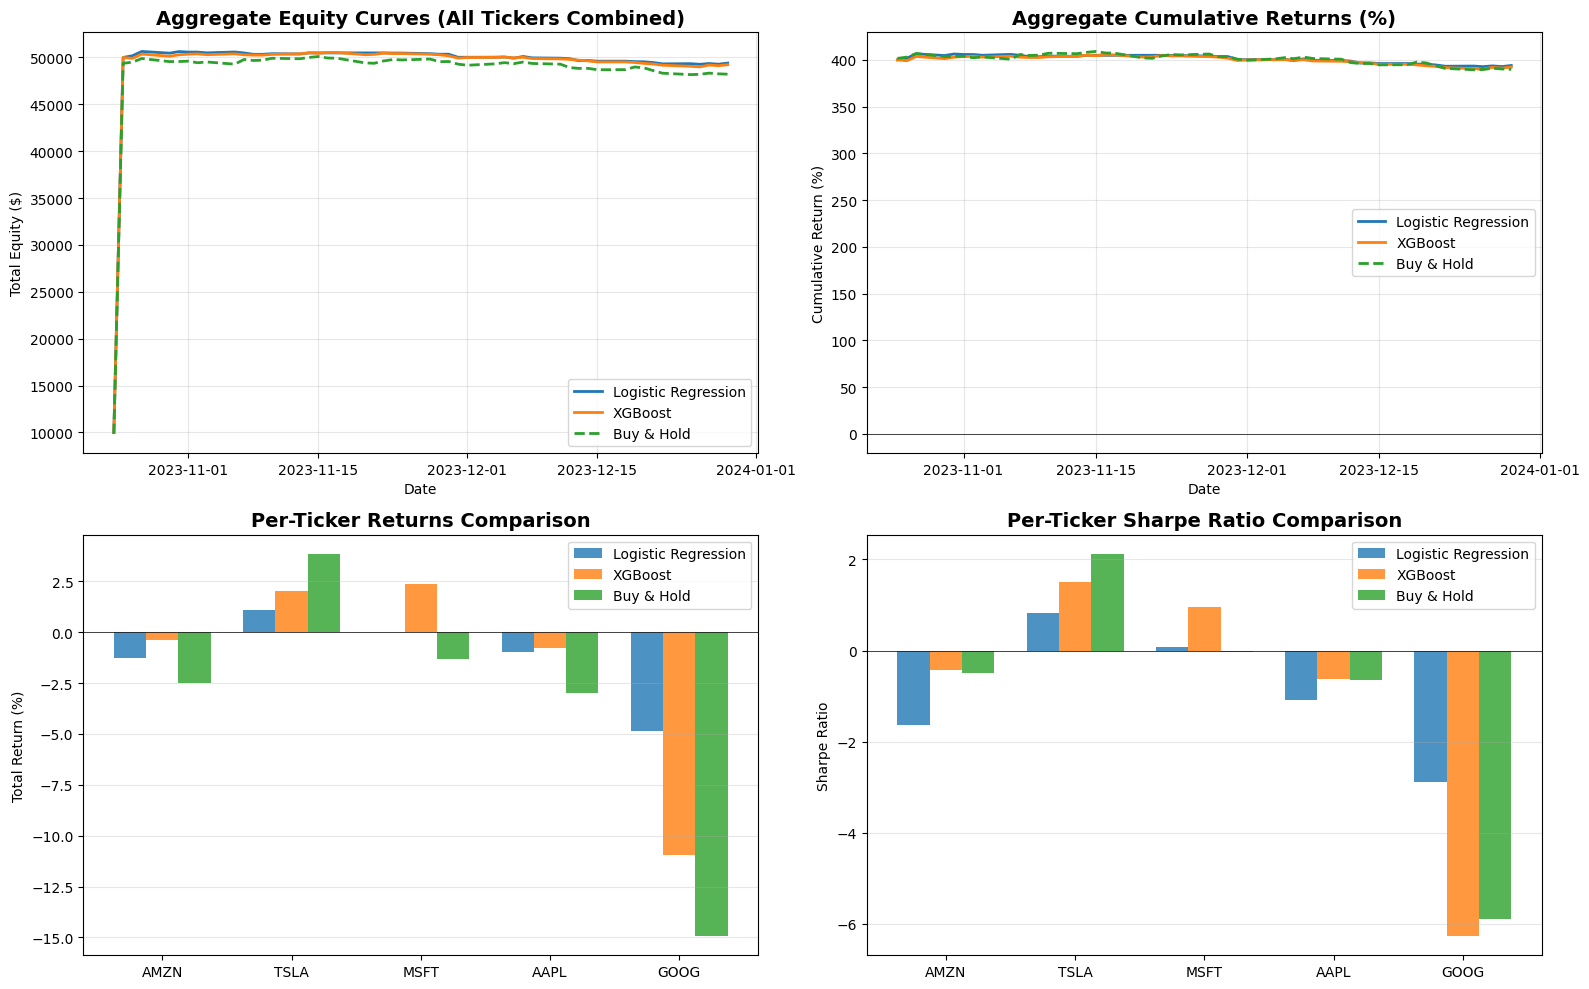

In [93]:
# Aggregate Equity Curves (Combined Portfolio)
# Combine equity curves across all tickers by date

def combine_equity_curves(ticker_equity_dict):
    """Combine equity curves from multiple tickers"""
    all_dates = set()
    for equity_df in ticker_equity_dict.values():
        all_dates.update(pd.to_datetime(equity_df['date']))
    
    all_dates = sorted(all_dates)
    combined_equity = []
    
    for date in all_dates:
        total_equity = 0
        for ticker, equity_df in ticker_equity_dict.items():
            equity_df['date'] = pd.to_datetime(equity_df['date'])
            date_match = equity_df[equity_df['date'] == date]
            if len(date_match) > 0:
                total_equity += date_match['equity'].iloc[0]
        combined_equity.append({
            'date': date,
            'equity': total_equity
        })
    
    combined_df = pd.DataFrame(combined_equity)
    combined_df['returns'] = combined_df['equity'].pct_change()
    combined_df['cumulative_returns'] = (1 + combined_df['returns']).cumprod() - 1
    
    return combined_df

lr_combined = combine_equity_curves(lr_ticker_equity)
xgb_combined = combine_equity_curves(xgb_ticker_equity)
bh_combined = combine_equity_curves(bh_ticker_equity)

# Plot aggregate equity curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Aggregate Equity Curves
ax1 = axes[0, 0]
ax1.plot(lr_combined['date'], lr_combined['equity'], label='Logistic Regression', linewidth=2)
ax1.plot(xgb_combined['date'], xgb_combined['equity'], label='XGBoost', linewidth=2)
ax1.plot(bh_combined['date'], bh_combined['equity'], label='Buy & Hold', linewidth=2, linestyle='--')
ax1.set_title('Aggregate Equity Curves (All Tickers Combined)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Equity ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Aggregate Cumulative Returns
ax2 = axes[0, 1]
ax2.plot(lr_combined['date'], lr_combined['cumulative_returns']*100, label='Logistic Regression', linewidth=2)
ax2.plot(xgb_combined['date'], xgb_combined['cumulative_returns']*100, label='XGBoost', linewidth=2)
ax2.plot(bh_combined['date'], bh_combined['cumulative_returns']*100, label='Buy & Hold', linewidth=2, linestyle='--')
ax2.set_title('Aggregate Cumulative Returns (%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Per-Ticker Returns Comparison (Bar Chart)
ax3 = axes[1, 0]
x = np.arange(len(unique_tickers))
width = 0.25

lr_returns = [lr_ticker_results[t]['total_return']*100 for t in unique_tickers]
xgb_returns = [xgb_ticker_results[t]['total_return']*100 for t in unique_tickers]
bh_returns = [bh_ticker_results[t]['total_return']*100 for t in unique_tickers]

ax3.bar(x - width, lr_returns, width, label='Logistic Regression', alpha=0.8)
ax3.bar(x, xgb_returns, width, label='XGBoost', alpha=0.8)
ax3.bar(x + width, bh_returns, width, label='Buy & Hold', alpha=0.8)

ax3.set_ylabel('Total Return (%)')
ax3.set_title('Per-Ticker Returns Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(unique_tickers)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Per-Ticker Sharpe Ratio Comparison
ax4 = axes[1, 1]
lr_sharpes = [lr_ticker_results[t]['sharpe_ratio'] for t in unique_tickers]
xgb_sharpes = [xgb_ticker_results[t]['sharpe_ratio'] for t in unique_tickers]
bh_sharpes = [bh_ticker_results[t]['sharpe_ratio'] for t in unique_tickers]

ax4.bar(x - width, lr_sharpes, width, label='Logistic Regression', alpha=0.8)
ax4.bar(x, xgb_sharpes, width, label='XGBoost', alpha=0.8)
ax4.bar(x + width, bh_sharpes, width, label='Buy & Hold', alpha=0.8)

ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Per-Ticker Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(unique_tickers)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

In [94]:
# Summary Statistics by Ticker
print("\n" + "="*100)
print("DETAILED PER-TICKER SUMMARY")
print("="*100)

for ticker in unique_tickers:
    print(f"\n{ticker}:")
    print("-" * 80)
    print(f"{'Metric':<30} {'Logistic Regression':<25} {'XGBoost':<25} {'Buy & Hold':<25}")
    print("-" * 80)
    
    lr_r = lr_ticker_results[ticker]
    xgb_r = xgb_ticker_results[ticker]
    bh_r = bh_ticker_results[ticker]
    
    print(f"{'Total Return (%)':<30} {lr_r['total_return']*100:>23.2f}% {xgb_r['total_return']*100:>23.2f}% {bh_r['total_return']*100:>23.2f}%")
    print(f"{'Final Capital ($)':<30} ${lr_r['final_capital']:>22,.2f} ${xgb_r['final_capital']:>22,.2f} ${bh_r['final_capital']:>22,.2f}")
    print(f"{'Sharpe Ratio':<30} {lr_r['sharpe_ratio']:>23.2f} {xgb_r['sharpe_ratio']:>23.2f} {bh_r['sharpe_ratio']:>23.2f}")
    print(f"{'Max Drawdown (%)':<30} {lr_r['max_drawdown']*100:>23.2f}% {xgb_r['max_drawdown']*100:>23.2f}% {bh_r['max_drawdown']*100:>23.2f}%")
    print(f"{'Number of Trades':<30} {lr_r['num_trades']:>23} {xgb_r['num_trades']:>23} {'N/A':>23}")


DETAILED PER-TICKER SUMMARY

AMZN:
--------------------------------------------------------------------------------
Metric                         Logistic Regression       XGBoost                   Buy & Hold               
--------------------------------------------------------------------------------
Total Return (%)                                 -1.26%                   -0.39%                   -2.50%
Final Capital ($)              $              9,873.83 $              9,960.71 $              9,750.25
Sharpe Ratio                                     -1.64                   -0.43                   -0.49
Max Drawdown (%)                                 -2.08%                   -2.05%                   -3.45%
Number of Trades                                     6                       9                     N/A

TSLA:
--------------------------------------------------------------------------------
Metric                         Logistic Regression       XGBoost                   B